In [1]:
from config import Config
from series_processing import process_series
from file_io import check_and_load_or_process
import numpy as np
from series_processing import process_series, bin_data
import matplotlib.pyplot as plt
import scipy
import pandas as pd

In [2]:
filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\large3"
offset = 19
num_files = 1
traces_per_file = 2

traces_HP = check_and_load_or_process("", offset, filename, "X", num_files, traces_per_file)

time_hp = np.arange(0, len(traces_HP[0]['series']))
conf_hp = Config(**traces_HP[0]['args'])
time_hp = time_hp * (1 / conf_hp.sampling_rate)
#
# filenameb = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\BariunTitanateAcetone\eod6_bright"
# offsetb = 1913667537
# num_filesb = 3
# traces_per_fileb = 2
#
# traces_HPb = check_and_load_or_process("", offsetb, filenameb, "X", num_filesb, traces_per_fileb)
#
# time_hpb = np.arange(0, len(traces_HPb[0]['series']))
# conf_hpb = Config(**traces_HPb[0]['args'])
# time_hpb = time_hpb * (1 / conf_hpb.sampling_rate)

Processing data for 
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\large3 0
data_col  X
MASS TOTAL IS 1.1309733552923254e-14


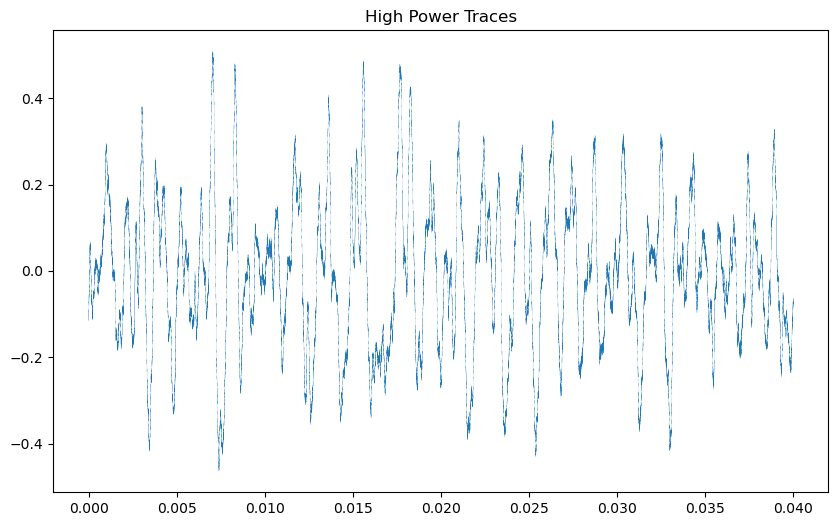

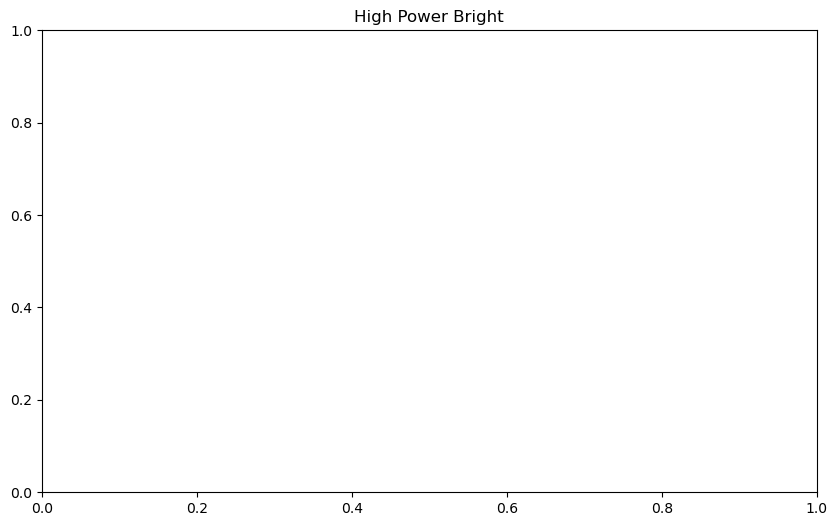

In [6]:
n = 1000000
full_series = traces_HP[0]['series']
series = traces_HP[0]['series'][0:n]
# seriesb = traces_HPb[2]['series'][0:n]
plt.figure(figsize=(10, 6))
plt.plot(time_hp[0:n], series, linewidth = .1)
plt.title("High Power Traces")
plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(time_hpb[0:n], seriesb, linewidth = 1)
plt.title("High Power Bright")
plt.show()

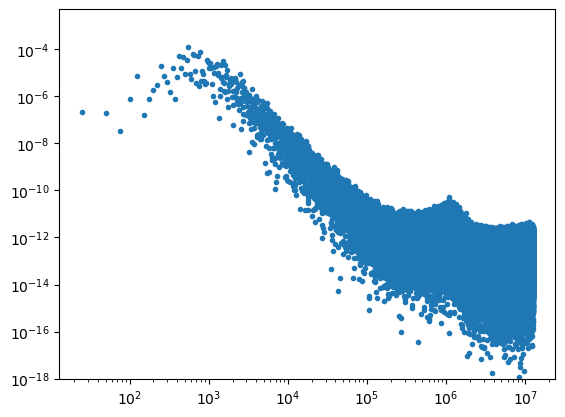

In [4]:
frequency, psd = scipy.signal.periodogram(series, fs=conf_hp.sampling_rate, scaling="density")
# frequencyb, psdb = scipy.signal.periodogram(seriesb, fs=conf_hpb.sampling_rate, scaling="density")

plt.plot(frequency, psd, ".")
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-18)
plt.show()
#
# plt.plot(frequencyb, psdb, ".")
# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(bottom=1e-18)
# plt.show()

In [5]:
#Holder number

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a function for length-scale scaling
def length_scale_analysis(time_trace, delta_t_values):
    lengths = []
    for delta_t in delta_t_values:
        steps = int(len(time_trace) / delta_t)
        trace_sections = [time_trace[i * delta_t: (i + 1) * delta_t] for i in range(steps)]

        # Calculate section lengths as cumulative distances
        section_lengths = [
            np.sum(np.abs(np.diff(section))) for section in trace_sections if len(section) > 1
        ]

        avg_length = np.mean(section_lengths) if section_lengths else 0
        lengths.append(avg_length)
    return lengths

# Define the scaling model for fitting
def scaling_model(delta_t, holder_exp, scale_factor):
    return scale_factor * (delta_t ** (1 - holder_exp))

# Function to estimate the Holder exponent
def estimate_holder_exponent(time_trace, min_delta_t=1, max_delta_t=100, num_points=50):
    delta_t_values = np.logspace(np.log10(min_delta_t), np.log10(max_delta_t), num_points, dtype=int)
    print(delta_t_values)
    delta_t_values = np.unique(delta_t_values)  # Remove duplicate values

    lengths = length_scale_analysis(time_trace, delta_t_values)

    # Fit the scaling model to the data
    valid_indices = np.where(np.array(lengths) > 0)
    delta_t_fit = delta_t_values[valid_indices]
    lengths_fit = np.array(lengths)[valid_indices]

    if len(delta_t_fit) < 2:
        raise ValueError("Not enough valid data points for fitting.")

    popt, _ = curve_fit(scaling_model, delta_t_fit, lengths_fit, p0=[0.5, 1.0])
    holder_exp = popt[0]

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.loglog(delta_t_values, lengths, 'o', label='Measured Lengths')
    plt.loglog(delta_t_values, scaling_model(delta_t_values, *popt), '-', label=f'Fit: H={holder_exp:.3f}')
    plt.xlabel('Delta t')
    plt.ylabel('Length')
    plt.title('Holder Exponent Estimation')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    return holder_exp

# Estimate the Holder exponent
holder_exp_result = estimate_holder_exponent(full_series, min_delta_t=1e-6, max_delta_t=1e-2, num_points=50)
print(f"Estimated Holder Exponent: {holder_exp_result:.3f}")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Users\mcthu\AppData\Local\Temp\ipykernel_26148\1938621767.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  steps = int(len(time_trace) / delta_t)


OverflowError: cannot convert float infinity to integer